# OpenCV

### Loading the dataset

- Yale faces database: http://vision.ucsd.edu/content/yale-face-database

In [1]:
from PIL import Image
import cv2
import numpy as np
# from google.colab.patches import cv2_imshow
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import zipfile
path = './yalefaces.zip'
zip_object = zipfile.ZipFile(file=path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

### Pre-processing the images

In [3]:
import os
print(os.listdir('./yalefaces/train/'))

['subject08.wink.gif', 'subject09.wink.gif', 'subject02.glasses.gif', 'subject15.happy.gif', 'subject06.noglasses.gif', 'subject11.noglasses.gif', 'subject03.sad.gif', 'subject05.normal.gif', 'subject14.leftlight.gif', 'subject15.noglasses.gif', 'subject02.noglasses.gif', 'subject06.rightlight.gif', 'subject13.rightlight.gif', 'subject06.centerlight.gif', 'subject10.leftlight.gif', 'subject09.centerlight.gif', 'subject02.wink.gif', 'subject03.wink.gif', 'subject11.sleepy.gif', 'subject14.rightlight.gif', 'subject01.rightlight.gif', 'subject08.sleepy.gif', 'subject14.sleepy.gif', 'subject12.glasses.gif', 'subject13.happy.gif', 'subject11.normal.gif', 'subject02.sad.gif', 'subject12.sad.gif', 'subject15.wink.gif', 'subject14.wink.gif', 'subject08.surprised.gif', 'subject12.noglasses.gif', 'subject05.noglasses.gif', 'subject07.glasses.gif', 'subject07.rightlight.gif', 'subject01.noglasses.gif', 'subject13.leftlight.gif', 'subject10.rightlight.gif', 'subject05.rightlight.gif', 'subject06.s

## 分裝資料跟標籤

In [7]:
def get_image_data():
  paths = [os.path.join('./yalefaces/train', f) for f in os.listdir('./yalefaces/train')]
  #print(paths)
  faces = []
  ids = []
  for path in paths:
    #print(path)
    image = Image.open(path).convert('L')
    #print(type(image))
    image_np = np.array(image, 'uint8')
    #print(type(image_np))
    id = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
    #print(id)
    ids.append(id)
    faces.append(image_np)

  return np.array(ids), faces

ids, faces = get_image_data()
print(len(ids), len(faces))
faces[0].shape

135 135


(243, 320)

## 訓練LBPH classifier

In [8]:
# threshold: 1.7976931348623157e+308
"""
# 預設寫法
lbph_classifier = cv2.face.LBPHFaceRecognizer_create()，其中參數：
radius: 局部二值模式的半径，默认值为 1。
neighbors: 每个像素点的邻域像素数，默认值为 8。
grid_x: 网格在 x 方向上的分割数，默认值为 8。
grid_y: 网格在 y 方向上的分割数，默认值为 8。
threshold: 阈值，用于识别阈值，默认值为 0。较小的值可能导致更高的误差率，较大的值可能导致更高的错误拒绝率。
"""

lbph_classifier = cv2.face.LBPHFaceRecognizer_create(radius = 4, neighbors=14, grid_x = 9, grid_y = 9)
lbph_classifier.train(faces, ids)
lbph_classifier.write('lbph_classifier.yml')

## 開始辨識人臉（單張）

In [10]:
lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_face_classifier.read('./lbph_classifier.yml')

In [15]:
test_image = './yalefaces/test/subject10.sad.gif'
image = Image.open(test_image).convert('L') # 轉灰階
image_np = np.array(image, 'uint8') # 轉np
print(image_np.shape, image_np)

""" 進行預測 """
prediction = lbph_face_classifier.predict(image_np)
prediction


(243, 320) [[130 130 130 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 241 255 255]
 [255 255 255 ... 234 237 252]
 [ 68  68  68 ...  68  68  68]]


(10, 36.84750735484425)

拿出預期答案進行比對

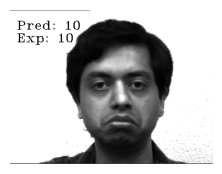

In [22]:
import matplotlib.pyplot as plt

expected_output = int(os.path.split(test_image)[1].split('.')[0].replace('subject', ''))

cv2.putText(image_np, 'Pred: ' + str(prediction[0]), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
cv2.putText(image_np, 'Exp: ' + str(expected_output), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
cv2.imshow("image_np",image_np)


# 顯示圖片
image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
plt.figure(figsize=(4, 2))
plt.axis('off')  # 隱藏坐標軸
plt.imshow(image_rgb)

## 評估 face classifier

In [26]:
paths = [os.path.join('./yalefaces/test', f) for f in os.listdir('./yalefaces/test')]
predictions = []
expected_outputs = []
for path in paths:
  #print(path)
  image = Image.open(path).convert('L')
  image_np = np.array(image, 'uint8')
  prediction, _ = lbph_face_classifier.predict(image_np)
  expected_output = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))

  predictions.append(prediction)
  expected_outputs.append(expected_output)

整個陣列轉np

In [30]:
print(type(predictions))
predictions = np.array(predictions)
expected_outputs = np.array(expected_outputs)
print(type(predictions))
print()
print("比較答案")
print(expected_outputs)
print(expected_outputs)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>

比較答案
[13  1  3  7  9  8 10 14 15  8  7  1  5 12  4  9 13 10 11  6  5  2  4 14
 11 15  3 12  6  2]
[13  1  3  7  9  8 10 14 15  8  7  1  5 12  4  9 13 10 11  6  5  2  4 14
 11 15  3 12  6  2]


使用混淆矩陣查看狀況

[[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 1]]
將混淆矩陣視覺化


<Axes: >

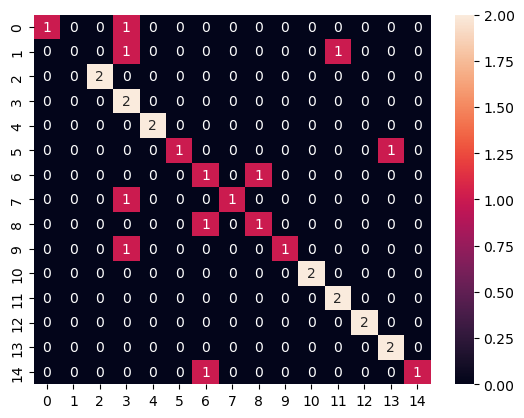

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
accuracy_score(expected_outputs, predictions)
cm = confusion_matrix(expected_outputs, predictions)
print(cm)

print("將混淆矩陣視覺化")
import seaborn
seaborn.heatmap(cm, annot=True)

# Dlib

處理dlib無法安裝問題 -> 要先安裝cMake
https://andy6804tw.github.io/2019/10/09/mac-fix-dlib-install/

### 偵測臉部點

In [40]:
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

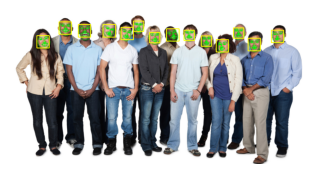

In [41]:
image = cv2.imread('./people2.jpg')
face_detection = face_detector(image, 1)
for face in face_detection:
  points = points_detector(image, face)
  for point in points.parts():
    cv2.circle(image, (point.x, point.y), 2, (0,255,0), 1)

  #print(points.parts())
  #print(len(points.parts()))

  l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
  cv2.rectangle(image, (l, t), (r, b), (0,255,255), 2)

# 顯示圖片
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
plt.figure(figsize=(4, 2))
plt.axis('off')  # 隱藏坐標軸
plt.imshow(image)

## 檢測臉部描述

相關文獻：https://arxiv.org/abs/1512.03385

In [59]:
import os
"""
dlib.get_frontal_face_detector()
碼使用了 dlib 中的正面人臉檢測器。這個檢測器專門設計用於檢測圖像中的人臉，並返回人臉的位置。
它基於 HOG 特徵和支持向量機（SVM）的組合來實現人臉檢測。

dlib.shape_predictor()
使用了一個預訓練的模型，用於檢測圖像中人臉的 68 個面部特徵點（如眼睛、鼻子、嘴巴等）。
這些特徵點的檢測可以用於進一步的面部分析、表情識別等應用。

dlib.face_recognition_model_v1()
使用了一個預訓練的模型，用於從人臉圖像中提取描述符（face descriptors）。
描述符是一個向量，用於表示人臉的特徵。這些描述符可以用於人臉識別、人臉比對等應用。
"""
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
face_descriptor_extractor = dlib.face_recognition_model_v1('./dlib_face_recognition_resnet_model_v1.dat')

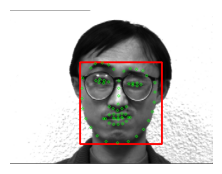

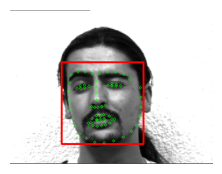

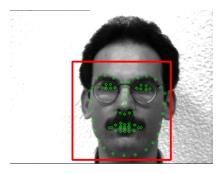

In [88]:
index = {}  # 索引字典，用於存儲每個人臉描述符對應的圖像路徑索引
idx = 0  # 索引值，用於追蹤每個人臉描述符的索引
face_descriptors = None  # 用於存儲人臉描述符的 NumPy 陣列

# 構建圖片路徑列表
paths = [os.path.join('./yalefaces/train', f) for f in os.listdir('./yalefaces/train')]
for i, path in enumerate(paths):
  # print(i, path)
  # 打開並轉換圖片為 RGB 格式
  image = Image.open(path).convert('RGB')
  image_np = np.array(image, 'uint8')
  
  # 找出圖片中的人臉位置
  face_detection = face_detector(image_np, 1)
  for face in face_detection:
    l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image_np, (l, t), (r, b), (0, 0, 255), 2)  # 畫出人臉框

    # 找出人臉的面部特徵點
    points = points_detector(image_np, face)
    for point in points.parts():
      cv2.circle(image_np, (point.x, point.y), 2, (0, 255, 0), 1)  # 在面部特徵點處畫圓

    # 計算人臉描述符
    face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
    # print(type(face_descriptor)) # <class '_dlib_pybind11.vector'>
    
    # 將人臉描述符轉換為 NumPy 陣列
    face_descriptor = np.asarray(face_descriptor, dtype=np.float64)
    face_descriptor = face_descriptor[np.newaxis, :]
    
    # 將人臉描述符添加到 face_descriptors 陣列中
    if face_descriptors is None:
      face_descriptors = face_descriptor
    else:
      face_descriptors = np.concatenate((face_descriptors, face_descriptor), axis=0)

    # 將索引與圖片路徑對應起來
    index[idx] = path
    idx += 1

# 顯示圖片(只讓他顯示三張就好)
  if i < 3:
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
    plt.figure(figsize=(4, 2))
    plt.axis('off')  # 隱藏坐標軸
    plt.imshow(image_np)


In [61]:
face_descriptors.shape # 132張圖，每張圖有128個值

(132, 128)

In [63]:
len(index), index

(132,
 {0: './yalefaces/train/subject08.wink.gif',
  1: './yalefaces/train/subject09.wink.gif',
  2: './yalefaces/train/subject02.glasses.gif',
  3: './yalefaces/train/subject15.happy.gif',
  4: './yalefaces/train/subject06.noglasses.gif',
  5: './yalefaces/train/subject11.noglasses.gif',
  6: './yalefaces/train/subject03.sad.gif',
  7: './yalefaces/train/subject05.normal.gif',
  8: './yalefaces/train/subject14.leftlight.gif',
  9: './yalefaces/train/subject15.noglasses.gif',
  10: './yalefaces/train/subject02.noglasses.gif',
  11: './yalefaces/train/subject06.rightlight.gif',
  12: './yalefaces/train/subject13.rightlight.gif',
  13: './yalefaces/train/subject06.centerlight.gif',
  14: './yalefaces/train/subject10.leftlight.gif',
  15: './yalefaces/train/subject09.centerlight.gif',
  16: './yalefaces/train/subject02.wink.gif',
  17: './yalefaces/train/subject03.wink.gif',
  18: './yalefaces/train/subject11.sleepy.gif',
  19: './yalefaces/train/subject14.rightlight.gif',
  20: './yalefa

## 計算臉與臉間的距離

計算了兩個向量之間的歐式距離

參考網址：https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm

In [56]:
print(np.linalg.norm(face_descriptors[131] - face_descriptors[131]))
print(np.linalg.norm(face_descriptors[131] - face_descriptors[130]))
print(np.linalg.norm(face_descriptors[131] - face_descriptors[129]))

0.0
0.695125969920898
0.683128302332133


array([0.        , 0.67500757, 0.72054189, 0.62420835, 0.60993762,
       0.75950951, 0.67675357, 0.77109193, 0.65048879, 0.63239037,
       0.78949344, 0.66277692, 0.61874439, 0.6214833 , 0.73358782,
       0.73299628, 0.77030387, 0.6641179 , 0.76635166, 0.57789391,
       0.25501609, 0.54020674, 0.83090876, 0.65248664, 0.75495416,
       0.75846281, 0.8158628 , 0.69919377, 0.55694284, 0.41725606,
       0.8333742 , 0.78509963, 0.71768762, 0.81522003, 0.78250707,
       0.7130352 , 0.79637999, 0.60152396, 0.6984634 , 0.56401971,
       0.68296571, 0.79046414, 0.75883599, 0.53038022, 0.77442759,
       0.8417544 , 0.66702721, 0.76199929, 0.48104888, 0.72084894,
       0.77693799, 0.72983073, 0.55160463, 0.78963571, 0.2950615 ,
       0.79232634, 0.32409617, 0.3588323 , 0.77688139, 0.35556493,
       0.77164228, 0.53720976, 0.78949344, 0.8088294 , 0.62146241,
       0.7667097 , 0.74823679, 0.76184708, 0.79258427, 0.69715551,
       0.54361413, 0.73453717, 0.66293383, 0.59333409, 0.63689

19

In [72]:
np.linalg.norm(face_descriptors[0] - face_descriptors[1:], axis = 1)[91]

0.29912789215531965

## 使用 Dlib 進行臉部偵測

In [ ]:
threshold = 0.5  # 設定閾值，用於判斷是否為同一人臉的閾值
predictions = []  # 存儲預測結果的列表
expected_outputs = []  # 存儲預期輸出的列表

# 構建測試圖片路徑列表
paths = [os.path.join('./yalefaces/test', f) for f in os.listdir('./yalefaces/test')]
for path in paths:
  # 打開並轉換圖片為 RGB 格式
  image = Image.open(path).convert('RGB')
  image_np = np.array(image, 'uint8')
  
  # 找出圖片中的人臉位置
  face_detection = face_detector(image_np, 1)
  for face in face_detection:
    # 找出人臉的面部特徵點
    points = points_detector(image_np, face)
    # 計算人臉描述符
    face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
    face_descriptor = [f for f in face_descriptor]
    face_descriptor = np.asarray(face_descriptor, dtype=np.float64)
    face_descriptor = face_descriptor[np.newaxis, :]

    # 計算當前人臉描述符與已知人臉描述符之間的歐式距離
    distances = np.linalg.norm(face_descriptor - face_descriptors, axis=1)
    # 找到與當前人臉描述符距離最小的索引
    min_index = np.argmin(distances)
    # 找到距離最小的距離值
    min_distance = distances[min_index]
    # 如果最小距離小於等於閾值，則認為是同一人臉，否則視為未識別到的人臉
    if min_distance <= threshold:
      name_pred = int(os.path.split(index[min_index])[1].split('.')[0].replace('subject', ''))
    else:
      name_pred = 'Not identified'

    # 獲取真實的人臉標籤
    name_real = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))

    # 將預測結果和真實標籤添加到對應的列表中
    predictions.append(name_pred)
    expected_outputs.append(name_real)

    # 在圖片上標註預測結果和真實標籤
    cv2.putText(image_np, 'Pred: ' + str(name_pred), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0))
    cv2.putText(image_np, 'Exp : ' + str(name_real), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0))

    # 顯示標註了預測結果和真實標籤的圖片
    image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
    plt.figure(figsize=(4, 2))
    plt.axis('off')  # 隱藏坐標軸
    plt.imshow(image_np)

# 將預測結果和真實標籤轉換為 NumPy 陣列
predictions = np.array(predictions)
expected_outputs = np.array(expected_outputs)

預測值
[13  1  3  7  9  8 10 14 15  8  7  1  5 12  4  9 13 10 11  6  5  2  4 14
 11 15  3 12  6  2]
解答
[13  1  3  7  9  8 10 14 15  8  7  1  5 12  4  9 13 10 11  6  5  2  4 14
 11 15  3 12  6  2]
準確率 1.0
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]]
將混淆矩陣視覺化


<Axes: >

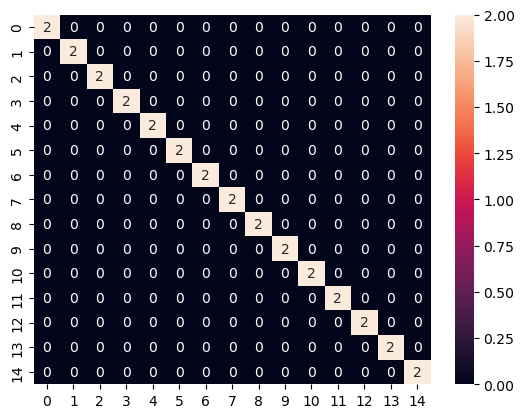

In [83]:
print("預測值")
print(predictions)
print("解答")
print(expected_outputs)

"""使用混淆矩陣進行查看"""
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
acc_score = accuracy_score(expected_outputs, predictions)
print("準確率", acc_score)
cm = confusion_matrix(expected_outputs, predictions)
print(cm)

print("將混淆矩陣視覺化")
import seaborn
seaborn.heatmap(cm, annot=True)



# Homework

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
import zipfile
path = './jones_gabriel.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [110]:
def get_image_data():
    paths = [os.path.join('./jones_gabriel', f) for f in os.listdir('./jones_gabriel')]
    faces = []
    ids = []
    print(paths)
    for path in paths:
        image = Image.open(path).convert('L')
        image_np = np.array(image, 'uint8')
        id = int(path.split('.')[3])
        ids.append(id)
        faces.append(image_np)
    return np.array(ids), faces


ids, faces = get_image_data()

['./jones_gabriel/person.2.5.jpg', './jones_gabriel/person.2.14.jpg', './jones_gabriel/person.2.15.jpg', './jones_gabriel/person.2.4.jpg', './jones_gabriel/person.2.6.jpg', './jones_gabriel/person.2.17.jpg', './jones_gabriel/person.2.16.jpg', './jones_gabriel/person.2.7.jpg', './jones_gabriel/person.2.3.jpg', './jones_gabriel/person.2.12.jpg', './jones_gabriel/person.2.13.jpg', './jones_gabriel/person.2.2.jpg', './jones_gabriel/person.2.11.jpg', './jones_gabriel/person.2.10.jpg', './jones_gabriel/person.2.1.jpg', './jones_gabriel/person.1.4.jpg', './jones_gabriel/person.1.5.jpg', './jones_gabriel/person.1.19.jpg', './jones_gabriel/person.1.25.jpg', './jones_gabriel/person.1.7.jpg', './jones_gabriel/person.1.6.jpg', './jones_gabriel/person.1.24.jpg', './jones_gabriel/person.1.18.jpg', './jones_gabriel/person.1.20.jpg', './jones_gabriel/person.1.2.jpg', './jones_gabriel/person.1.3.jpg', './jones_gabriel/person.1.21.jpg', './jones_gabriel/person.1.23.jpg', './jones_gabriel/person.1.1.jpg'

## 使用opencv人臉辨識

In [111]:
# 訓練模型
lbph_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_classifier.train(faces, ids)
lbph_classifier.write('lbph_classifier.yml')

# 讀取模型
lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_face_classifier.read('./lbph_classifier.yml')

# 抓一張圖片起來做測試
image = Image.open('./jones_gabriel/person.1.1.jpg')
print(image.size)

# 做全部圖片的辨識
paths = [os.path.join('./jones_gabriel', f) for f in os.listdir('./jones_gabriel')]
for i, path in enumerate(paths):
  image = Image.open(path).convert('L')
  image_np = np.array(image, 'uint8')
  prediction, _ = lbph_face_classifier.predict(image_np)
  expected_output = int(path.split('.')[3])

  cv2.putText(image_np, 'Pred: ' + str(prediction), (10,30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0))
  cv2.putText(image_np, 'Exp: ' + str(expected_output), (10,50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0))

  # 顯示圖片（只顯示三張）
  if i < 3:
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
    plt.figure(figsize=(4, 2))
    plt.axis('off')  # 隱藏坐標軸
    plt.imshow(image_np)

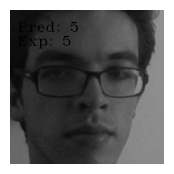

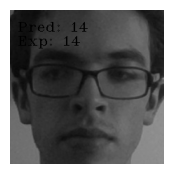

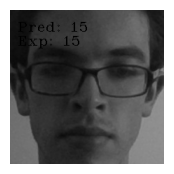

## 使用dlib做人臉辨識

In [121]:
import os
"""
dlib.get_frontal_face_detector()
碼使用了 dlib 中的正面人臉檢測器。這個檢測器專門設計用於檢測圖像中的人臉，並返回人臉的位置。
它基於 HOG 特徵和支持向量機（SVM）的組合來實現人臉檢測。

dlib.shape_predictor()
使用了一個預訓練的模型，用於檢測圖像中人臉的 68 個面部特徵點（如眼睛、鼻子、嘴巴等）。
這些特徵點的檢測可以用於進一步的面部分析、表情識別等應用。

dlib.face_recognition_model_v1()
使用了一個預訓練的模型，用於從人臉圖像中提取描述符（face descriptors）。
描述符是一個向量，用於表示人臉的特徵。這些描述符可以用於人臉識別、人臉比對等應用。
"""
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
face_descriptor_extractor = dlib.face_recognition_model_v1('./dlib_face_recognition_resnet_model_v1.dat')

[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) (216, 242)]
[(-31, 19) 

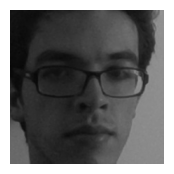

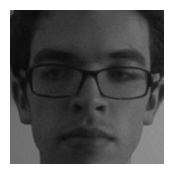

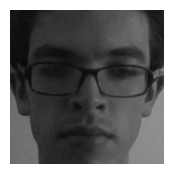

In [126]:
index = {}  # 索引字典，用於存儲每個人臉描述符對應的圖像路徑索引
idx = 0  # 索引值，用於追蹤每個人臉描述符的索引
face_descriptors = None  # 用於存儲人臉描述符的 NumPy 陣列

# 構建圖片路徑列表
paths = [os.path.join('./jones_gabriel', f) for f in os.listdir('./jones_gabriel')]
for i, path in enumerate(paths):
  # print(i, path)
  # 打開並轉換圖片為 RGB 格式
  image = Image.open(path).convert('RGB')
  image_np = np.array(image, 'uint8')
  
  # 找出圖片中的人臉位置
  face_detection = face_detector(image_np, 1)
  # print(face)
  for face in face_detection:
    l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image_np, (l, t), (r, b), (255, 255, 255), 2)  # 畫出人臉框

    # 找出人臉的面部特徵點
    points = points_detector(image_np, face)
    for point in points.parts():
      cv2.circle(image_np, (point.x, point.y), 2, (0, 255, 0), 3)  # 在面部特徵點處畫圓

    # 計算人臉描述符
    face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
    
    # 將人臉描述符轉換為 NumPy 陣列
    face_descriptor = np.asarray(face_descriptor, dtype=np.float64)
    face_descriptor = face_descriptor[np.newaxis, :]
    
    # 將人臉描述符添加到 face_descriptors 陣列中
    if face_descriptors is None:
      face_descriptors = face_descriptor
    else:
      face_descriptors = np.concatenate((face_descriptors, face_descriptor), axis=0)

    # 將索引與圖片路徑對應起來
    index[idx] = path
    idx += 1

# 顯示圖片(只讓他顯示三張就好)
  if i < 3:
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
    plt.figure(figsize=(4, 2))
    plt.axis('off')  # 隱藏坐標軸
    plt.imshow(image_np)


/var/folders/sw/9p5t6n_s5slgb49wh4jkfkk00000gn/T/ipykernel_47170/2772178206.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4, 2))


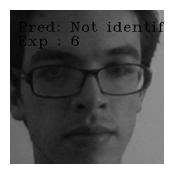

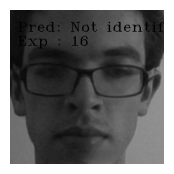

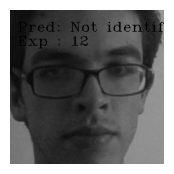

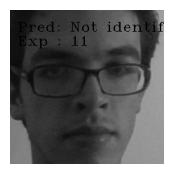

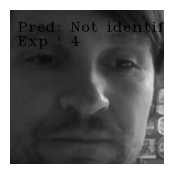

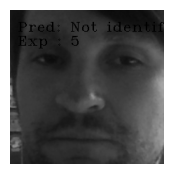

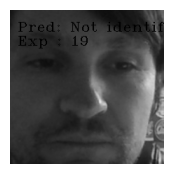

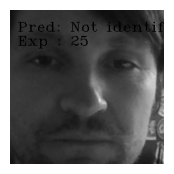

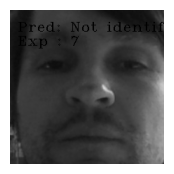

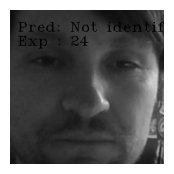

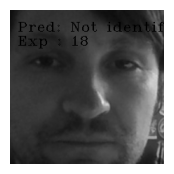

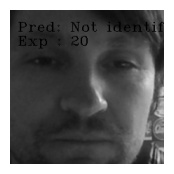

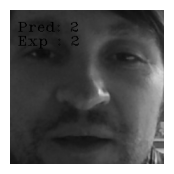

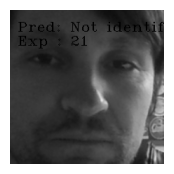

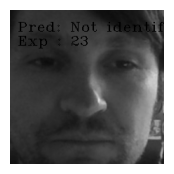

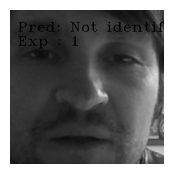

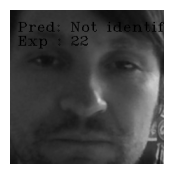

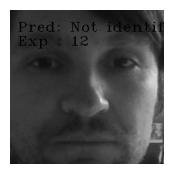

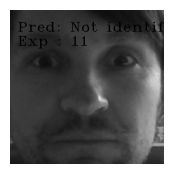

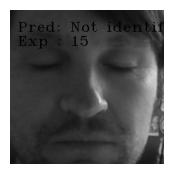

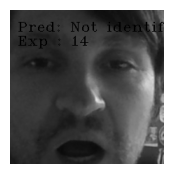

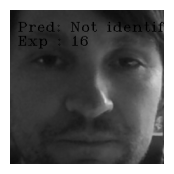

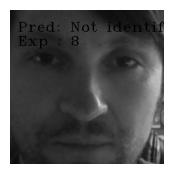

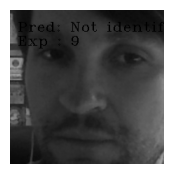

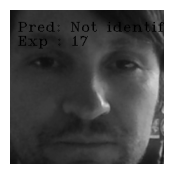

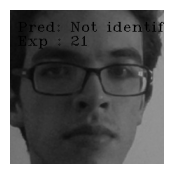

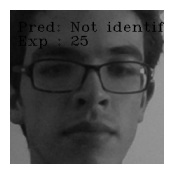

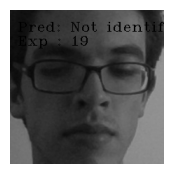

In [128]:
threshold = 0.5  # 設定閾值，用於判斷是否為同一人臉的閾值
predictions = []  # 存儲預測結果的列表
expected_outputs = []  # 存儲預期輸出的列表

# 構建測試圖片路徑列表
paths = [os.path.join('./jones_gabriel/', f) for f in os.listdir('./jones_gabriel/')]
for path in paths:
  # 打開並轉換圖片為 RGB 格式
  image = Image.open(path).convert('RGB')
  image_np = np.array(image, 'uint8')
  
  # 找出圖片中的人臉位置
  face_detection = face_detector(image_np, 1)
  for face in face_detection:
    # 找出人臉的面部特徵點
    points = points_detector(image_np, face)
    # 計算人臉描述符
    face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
    face_descriptor = [f for f in face_descriptor]
    face_descriptor = np.asarray(face_descriptor, dtype=np.float64)
    face_descriptor = face_descriptor[np.newaxis, :]

    # 計算當前人臉描述符與已知人臉描述符之間的歐式距離
    distances = np.linalg.norm(face_descriptor - face_descriptors, axis=1)
    # 找到與當前人臉描述符距離最小的索引
    min_index = np.argmin(distances)
    # 找到距離最小的距離值
    min_distance = distances[min_index]
    # 如果最小距離小於等於閾值，則認為是同一人臉，否則視為未識別到的人臉
    if min_distance <= threshold:
      name_pred = int(path.split('.')[3])
    else:
      name_pred = 'Not identified'

    # 獲取真實的人臉標籤
    name_real = int(path.split('.')[3])

    # 將預測結果和真實標籤添加到對應的列表中
    predictions.append(name_pred)
    expected_outputs.append(name_real)

    # 在圖片上標註預測結果和真實標籤
    cv2.putText(image_np, 'Pred: ' + str(name_pred), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0))
    cv2.putText(image_np, 'Exp : ' + str(name_real), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0))

    # 顯示標註了預測結果和真實標籤的圖片
    image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
    plt.figure(figsize=(4, 2))
    plt.axis('off')  # 隱藏坐標軸
    plt.imshow(image_np)

# 將預測結果和真實標籤轉換為 NumPy 陣列
predictions = np.array(predictions)
expected_outputs = np.array(expected_outputs)

In [ ]:
print("預測值")
print(predictions)
print("解答")
print(expected_outputs)

"""使用混淆矩陣進行查看"""
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
acc_score = accuracy_score(expected_outputs, predictions)
print("準確率", acc_score)
cm = confusion_matrix(expected_outputs, predictions)
print(cm)

print("將混淆矩陣視覺化")
import seaborn
seaborn.heatmap(cm, annot=True)

